In [4]:
import os
import re
import json
import random
import collections
from pprint import pprint
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import scipy

from eztrack.utils import warn
from mne_bids import read_raw_bids, BIDSPath, get_entity_vals

from pprint import pprint
from natsort import natsorted, index_natsorted, order_by_index
import scipy
from scipy import interp
from sklearn import preprocessing
from sklearn import random_projection

from eztrack.fragility.linearsystem import DiscreteLinearSystem
from eztrack.fragility.perturbationmodel import MinNormPerturbModel

import sys
import math
from pathlib import Path

from mne.io import RawArray
from mne import create_info

from eztrack import (
    preprocess_raw,
    lds_raw_fragility,
    write_result_fragility,
    plot_result_heatmap,
)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# from pathlib import Path

# from eztrack import (
#     plot_result_heatmap,
# read_result_eztrack,
# Result
# )
# from eztrack.io.base import _add_desc_to_bids_fname, DERIVATIVETYPES
# from eztrack.fragility.fragility import state_perturbation_array
# from eztrack.io.write_result import write_result_array
# from mne_bids import read_raw_bids, BIDSPath, get_entity_vals
# from mne.utils import warn



In [55]:
def load_low_high_system(bids_path, l_freq=0.5, splitfreq=90, h_freq=400, verbose=True):
    # load in the data
    raw = read_raw_bids(bids_path)
    raw = raw.pick_types(seeg=True, ecog=True, eeg=True, misc=False)
    
    # drop bad channels
    bad_chs = raw.info['bads']
    raw.drop_channels(bad_chs)

    # mask data based on channel type
    raw.pick_types(eeg=True, seeg=True, ecog=True, misc=False, exclude=[])

    # load in the data to RAM
    if not raw.preload:
        raw.load_data()

    # filter out nyquist and its bands
    line_freq = raw.info['line_freq']
    nyq_freq = raw.info['sfreq'] // 2
    freqs = np.arange(line_freq, max(h_freq, nyq_freq), line_freq)
    raw = raw.notch_filter(freqs=freqs, method="fir", verbose=verbose)
    
    # create two copies
    low_raw = raw.copy()
    high_raw = raw.copy()
    
    # pre-process the data using preprocess pipeline
    datatype = bids_path.datatype
    low_raw = low_raw.filter(l_freq=l_freq, h_freq=splitfreq, verbose=verbose)
    high_raw = high_raw.filter(l_freq=splitfreq, h_freq=h_freq, verbose=verbose)
    
    # create raw
    ch_names = [f'{ch}-low' for ch in low_raw.ch_names]
    ch_names.extend([f'{ch}-high' for ch in high_raw.ch_names])
    new_info = create_info(ch_names, sfreq=raw.info['sfreq'], ch_types='ecog')
    arr = np.concatenate((low_raw.get_data(), high_raw.get_data()), axis=0)
    
    print(arr.shape)
    raw = RawArray(arr, info=new_info)
    return high_raw

In [56]:
def run_analysis(
        bids_path, reference="monopolar", resample_sfreq=None, deriv_path=None,
        figures_path=None, excel_fpath=None, verbose=True, overwrite=False,
):
    subject = bids_path.subject
    datatype = bids_path.datatype


    if deriv_path is None:
        deriv_path = (
                bids_path.root
                / "derivatives"
        )
    deriv_path = (deriv_path
                  / f"lowandhigh"
                  / "fragility"
                  / reference
                  / f"sub-{subject}")
    # set where to save the data output to
    if figures_path is None:
        figures_path = (
                bids_path.root
                / "derivatives"
                / "figures"
        )
    figures_path = (figures_path
                    / f"lowandhigh"
                    / "fragility"
                    / reference
                    / f"sub-{subject}")

    # use the same basename to save the data
    deriv_basename = bids_path.basename
#     deriv_basename = _add_desc_to_bids_fname(
#         deriv_basename, description=DERIVATIVETYPES.ROWPERTURB_MATRIX.value, verbose=False
#     )
    deriv_fpath = deriv_path / deriv_basename
#     if deriv_fpath.exists() and not overwrite:
#         warn(f'The {deriv_basename}.npy exists, but overwrite if False.')
#         return

    raw = load_low_high_system(bids_path, l_freq=0.5, splitfreq=90, h_freq=400, verbose=True)

    model_params = {
        "winsize": 250,
        "stepsize": 125,
        "radius": 1.5,
        "method_to_use": "pinv",
        'perturb_type': 'R',
#         'l2_penalty': 1e-2,
    }
    # run heatmap
#     raw = raw.crop(tmin=0, tmax=20)
    result, A_mats, delta_vecs_arr = lds_raw_fragility(
        raw, reference=reference, return_all=True, **model_params
    )

    # write results to
    result_sidecars = write_result_fragility(
        A_mats,
        delta_vecs_arr,
        result=result,
        deriv_basename=deriv_basename,
        deriv_path=deriv_path,
        verbose=verbose,
    )
    fig_basename = deriv_basename

    result.normalize()
    # create the heatmap
    plot_result_heatmap(
        result=result,
        fig_basename=fig_basename,
        figures_path=figures_path,
        excel_fpath=excel_fpath
    )
    
    # write results to
#     source_entities = bids_path.entities
#     raw_basename = BIDSPath(**source_entities).basename
#     deriv_fname = list(deriv_path.glob(f'{raw_basename}*statematrix*'))[0]
#     state_arr, result_info, metadata = read_result_eztrack(deriv_fname=deriv_fname,
#                                  description='statematrix',
#                                  normalize=False)

#     # run row perturbation
#     radius = 1.5
#     perturb_type = 'C'
#     pert_mats, delta_vecs_arr = state_perturbation_array(state_arr,
#                                                          radius=radius,
#                                                          perturb_type=perturb_type,
#                                                          n_jobs=-1)

#     # write results to
#     pert_sidecar = write_result_array(
#         pert_mats,
#         metadata=metadata,
#         deriv_fpath=deriv_fpath,
#         verbose=verbose,
#     )
#     fig_basename = deriv_basename

#     result = Result(pert_mats, raw.info, metadata=metadata)
#     result.normalize()
#     # create the heatmap
#     plot_result_heatmap(
#         result=result,
#         fig_basename=fig_basename,
#         figures_path=figures_path,
#         excel_fpath=excel_fpath
#     )


In [ ]:
WORKSTATION = "home"

if WORKSTATION == "home":
    # bids root to write BIDS data to
    # the root of the BIDS dataset
    root = Path("/Users/adam2392/Dropbox/epilepsy_bids/")
    output_dir = root / 'derivatives' / 'interictal'

    figures_dir = output_dir / 'figures'

    # path to excel layout file - would be changed to the datasheet locally
    excel_fpath = Path(
        "/Users/adam2392/Dropbox/epilepsy_bids/sourcedata/organized_clinical_datasheet_raw.xlsx"
    )
elif WORKSTATION == "lab":
    root = Path("/home/adam2392/hdd/epilepsy_bids/")
    excel_fpath = Path(
        "/home/adam2392/hdd/epilepsy_bids/sourcedata/organized_clinical_datasheet_raw.xlsx"
    )

    # output directory
    output_dir = Path("/home/adam2392/hdd2") / 'derivatives' / 'interictal'

    # figures directory
    figures_dir = output_dir / 'figures'

# define BIDS entities
SUBJECTS = [
    'pt1', 'pt2', 'pt3',  # NIH
#     'jh103', 'jh105',  # JHH
    # 'umf001', 'umf002', 'umf003', 'umf005', # UMF
]

session = "presurgery"  # only one session
task = "interictal"
datatype = "ieeg"
acquisition = "ecog"  # or SEEG
extension = ".vhdr"

if acquisition == 'ecog':
    ignore_acquisitions = ['seeg']
elif acquisition == 'seeg':
    ignore_acquisitions = ['ecog']

# analysis parameters
reference = 'monopolar'
sfreq = None  # either resample or don't

# get the runs for this subject
all_subjects = get_entity_vals(root, "subject")

for subject in all_subjects:
    if subject not in SUBJECTS:
        continue
    
    ignore_subs = [sub for sub in all_subjects if sub != subject]
    all_tasks = get_entity_vals(root, "task", ignore_subjects=ignore_subs)
    ignore_tasks = [tsk for tsk in all_tasks if tsk != task]

    print(f"Analyzing {task} task for {subject}.")
    ignore_tasks = [tsk for tsk in all_tasks if tsk != task]
    runs = get_entity_vals(
        root, 'run', ignore_subjects=ignore_subs,
        ignore_tasks=ignore_tasks,
        ignore_acquisitions=ignore_acquisitions
    )
    print(f'Found {runs} runs for {task} task.')

    for idx, run in enumerate(runs):
        # create path for the dataset
        bids_path = BIDSPath(
            subject=subject,
            session=session,
            task=task,
            run=run,
            datatype=datatype,
            acquisition=acquisition,
            suffix=datatype,
            root=root,
            extension=extension,
        )
        print(f"Analyzing {bids_path}")

        run_analysis(bids_path, reference=reference,
                     resample_sfreq=sfreq,
                     deriv_path=output_dir, figures_path=figures_dir,
                     excel_fpath=excel_fpath,
                     overwrite=False
                     )
#         break
#     break

Analyzing interictal task for pt1.
Found ['01', '02', '03', '04'] runs for interictal task.
Analyzing /Users/adam2392/Dropbox/epilepsy_bids/sub-pt1/ses-presurgery/ieeg/sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-01_ieeg.vhdr


<ipython-input-55-21d5a52d436d>:3: RuntimeWarning: Did not find any electrodes.tsv associated with sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-01.

The search_str was "/Users/adam2392/Dropbox/epilepsy_bids/sub-pt1/**/sub-pt1_ses-presurgery*electrodes.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-55-21d5a52d436d>:3: RuntimeWarning: Did not find any coordsystem.json associated with sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-01.

The search_str was "/Users/adam2392/Dropbox/epilepsy_bids/sub-pt1/**/sub-pt1_ses-presurgery*coordsystem.json"
  raw = read_raw_bids(bids_path)


(168, 405170)




  0%|          | 0/3240 [00:00<?, ?it/s]

  0%|          | 4/3240 [00:00<01:54, 28.21it/s]

  0%|          | 8/3240 [00:05<21:37,  2.49it/s]

  0%|          | 12/3240 [00:05<16:23,  3.28it/s]

  0%|          | 16/3240 [00:05<12:29,  4.30it/s]

  1%|          | 20/3240 [00:05<09:43,  5.52it/s]

  1%|          | 24/3240 [00:06<07:44,  6.92it/s]

  1%|          | 28/3240 [00:06<06:22,  8.40it/s]

  1%|          | 32/3240 [00:06<05:39,  9.44it/s]

  1%|          | 36/3240 [00:07<04:55, 10.84it/s]

  1%|          | 40/3240 [00:07<04:24, 12.10it/s]

  1%|▏         | 44/3240 [00:07<04:02, 13.15it/s]

  1%|▏         | 48/3240 [00:07<03:56, 13.50it/s]

  2%|▏         | 52/3240 [00:08<04:01, 13.22it/s]

  2%|▏         | 56/3240 [00:08<03:46, 14.06it/s]

  2%|▏         | 60/3240 [00:08<03:35, 14.74it/s]

  2%|▏         | 64/3240 [00:08<03:35, 14.73it/s]

  2%|▏         | 68/3240 [00:09<03:28, 15.24it/s]

  2%|▏         | 72/3240 [00:09<03:35, 14.73it/s]

  2%|▏         | 76/3240 [00:09<03:28, 1

{'Author': 'adam2392',
 'Description': 'Delta vector array (columns by perturbation index by time).',
 'RawSources': ['sub-pt1/ses-presurgery/ieeg/sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-01_ieeg'],
 'ResultFileName': 'sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-01_desc-deltavecsmatrix_ieeg.npy',
 'ResultShape': (84, 84, 3240),
 'ch_names': ['G1',
              'G2',
              'G3',
              'G4',
              'G7',
              'G8',
              'G9',
              'G10',
              'G13',
              'G14',
              'G15',
              'G16',
              'G17',
              'G18',
              'G19',
              'G20',
              'G21',
              'G22',
              'G23',
              'G11',
              'G12',
              'G24',
              'G25',
              'G26',
              'G27',
              'G28',
              'G29',
              'G30',
              'G31',
              'G32',
              'ATT1',
      

<ipython-input-55-21d5a52d436d>:3: RuntimeWarning: Did not find any electrodes.tsv associated with sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-02.

The search_str was "/Users/adam2392/Dropbox/epilepsy_bids/sub-pt1/**/sub-pt1_ses-presurgery*electrodes.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-55-21d5a52d436d>:3: RuntimeWarning: Did not find any coordsystem.json associated with sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-02.

The search_str was "/Users/adam2392/Dropbox/epilepsy_bids/sub-pt1/**/sub-pt1_ses-presurgery*coordsystem.json"
  raw = read_raw_bids(bids_path)


(168, 498170)




  0%|          | 0/3984 [00:00<?, ?it/s]

  0%|          | 8/3984 [00:00<04:15, 15.55it/s]

  0%|          | 12/3984 [00:00<04:31, 14.64it/s]

  0%|          | 16/3984 [00:01<04:30, 14.65it/s]

  1%|          | 20/3984 [00:01<04:23, 15.05it/s]

  1%|          | 24/3984 [00:01<04:18, 15.32it/s]

  1%|          | 28/3984 [00:01<04:13, 15.60it/s]

  1%|          | 32/3984 [00:02<04:26, 14.84it/s]

  1%|          | 36/3984 [00:02<04:24, 14.95it/s]

  1%|          | 40/3984 [00:02<04:21, 15.09it/s]

  1%|          | 44/3984 [00:02<04:17, 15.27it/s]

  1%|          | 48/3984 [00:03<04:38, 14.15it/s]

  1%|▏         | 52/3984 [00:03<04:39, 14.06it/s]

  1%|▏         | 56/3984 [00:03<04:41, 13.97it/s]

  2%|▏         | 60/3984 [00:04<04:39, 14.03it/s]

  2%|▏         | 64/3984 [00:04<04:50, 13.49it/s]

  2%|▏         | 68/3984 [00:04<04:45, 13.74it/s]

  2%|▏         | 72/3984 [00:04<04:36, 14.16it/s]

  2%|▏         | 76/3984 [00:05<04:36, 14.16it/s]

  2%|▏         | 80/3984 [00:05<04:47, 

{'Author': 'adam2392',
 'Description': 'Delta vector array (columns by perturbation index by time).',
 'RawSources': ['sub-pt1/ses-presurgery/ieeg/sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-02_ieeg'],
 'ResultFileName': 'sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-02_desc-deltavecsmatrix_ieeg.npy',
 'ResultShape': (84, 84, 3984),
 'ch_names': ['G1',
              'G2',
              'G3',
              'G4',
              'G7',
              'G8',
              'G9',
              'G10',
              'G13',
              'G14',
              'G15',
              'G16',
              'G17',
              'G18',
              'G19',
              'G20',
              'G21',
              'G22',
              'G23',
              'G11',
              'G12',
              'G24',
              'G25',
              'G26',
              'G27',
              'G28',
              'G29',
              'G30',
              'G31',
              'G32',
              'ATT1',
      

 35%|███▍      | 55/159 [14:54<28:11, 16.27s/it]


['PD1', 'PD2', 'PD3', 'PD4', 'AD1', 'AD2', 'AD3', 'AD4', 'ATT1', 'ATT2']
{}
The ytick labels [Text(0, 0, 'G1'), Text(0, 1, 'G2'), Text(0, 2, 'G3'), Text(0, 3, 'G4'), Text(0, 4, 'G7')]... to change are {}.
Analyzing /Users/adam2392/Dropbox/epilepsy_bids/sub-pt1/ses-presurgery/ieeg/sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-03_ieeg.vhdr


<ipython-input-55-21d5a52d436d>:3: RuntimeWarning: Did not find any electrodes.tsv associated with sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-03.

The search_str was "/Users/adam2392/Dropbox/epilepsy_bids/sub-pt1/**/sub-pt1_ses-presurgery*electrodes.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-55-21d5a52d436d>:3: RuntimeWarning: Did not find any coordsystem.json associated with sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-03.

The search_str was "/Users/adam2392/Dropbox/epilepsy_bids/sub-pt1/**/sub-pt1_ses-presurgery*coordsystem.json"
  raw = read_raw_bids(bids_path)


(168, 425010)



 84%|████████▍ | 2864/3399 [03:48<00:35, 14.91it/s]

In [53]:
np.mean(raw.get_data()[:84, :])
np.mean(raw.get_data()[84:, :])

np.mean(raw.get_data()[:84, :]) / np.mean(raw.get_data()[84:, :])

-19480.24585294094

[ 2.49806615e-04  2.65034248e-04 -4.98675928e-05 -1.52284154e-04
 -4.16298584e-05  1.74974493e-04  2.41992177e-04  1.90497123e-04
  3.06196259e-04  8.85804548e-05 -1.17457013e-06  1.40777794e-04
  2.49441128e-04  1.01351876e-04  9.37746087e-06  7.38770435e-05
  2.63682660e-05  9.27490625e-05  6.45161297e-05 -1.44670547e-04
 -1.81812097e-04  2.27132171e-04  8.66551610e-05 -9.10161670e-05
 -4.77566530e-05  4.68199737e-05  4.51843302e-05  9.78263652e-05
 -6.74360568e-05 -1.48940219e-04 -1.70379621e-04 -4.76321206e-05
  5.85353607e-05  6.12282308e-05  3.96043637e-05  9.31470638e-05
  6.38837456e-05  1.05631112e-04  1.96797058e-05  6.66173329e-05
 -5.48208755e-05 -4.20391644e-05  1.06384241e-04 -7.97185826e-05
  2.18056910e-05 -1.20767390e-03  5.82171246e-05  7.75639908e-05
  1.27367902e-04 -5.20216286e-05  8.80211014e-05 -7.00946608e-05
 -1.96758470e-05  3.42424565e-05  1.18110663e-06  2.09784511e-05
  7.54429074e-05 -2.49428819e-06  1.09916177e-04  1.34666526e-04
  1.46510918e-04  2.97227

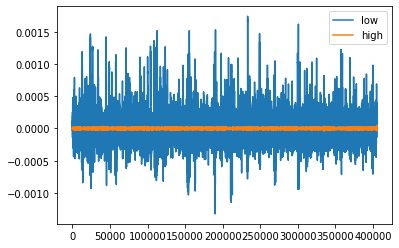

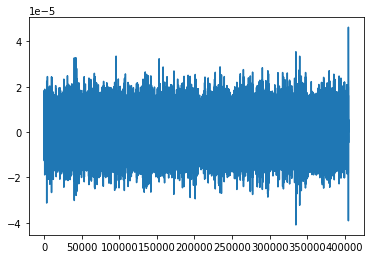

In [49]:
print(raw.get_data()[:84, 40])
plt.plot(np.mean(raw.get_data()[:84, :], axis=0), label='low')
plt.plot(np.mean(raw.get_data()[84:, :], axis=0), label='high')
plt.legend()

plt.figure()
plt.plot(np.mean(raw.get_data()[84:, :], axis=0) + (np.mean(raw.get_data()[:84, :]) - np.mean(raw.get_data()[84:, :])), label='high on low')
# plt.plot(np.mean(raw.get_data()[:84, :], axis=0), label='low')